In [1]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
    ("proteun4", "AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS")
]

In [2]:
print(alphabet)


In [3]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)

In [4]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[32], return_contacts=True)
token_representations = results["representations"][32]

In [5]:
token_representations[0].shape

torch.Size([288, 1280])

In [6]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
    print(token_representations[i].shape)

torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])


In [7]:
sequence_representations

[tensor([ 4.6987, -2.3694, -0.3084,  ..., -4.0112, -3.2634, -1.0328]),
 tensor([ 4.4958, -0.9851,  2.9237,  ..., -4.4470, -1.6426, -0.5239]),
 tensor([ 5.2587, -1.3039,  2.9077,  ..., -4.9862, -0.4840, -1.0121]),
 tensor([ -1.7384,  -6.8481,   5.2880,  ...,  -4.2909,   4.1356, -13.5250]),
 tensor([ 1.7132,  3.1321, -2.3060,  ...,  3.1544,  2.6045,  2.5149])]

## Attention representation

We may have more information if we can do the regression from the attention matrix.
The issue is that the size of the attention matrix depends on the length of the sequence. It could be that we could use the entire length that has zeros but then the regression model may get biased toward that.

How to go for a varying length attention representation to a regression??

torch.Size([286, 286])


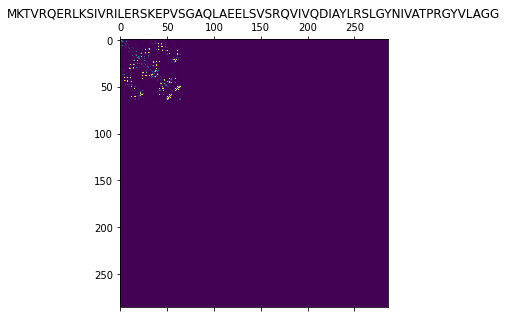

torch.Size([286, 286])


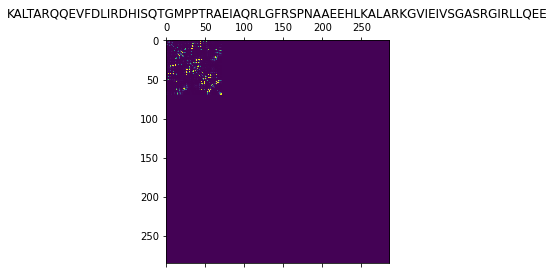

torch.Size([286, 286])


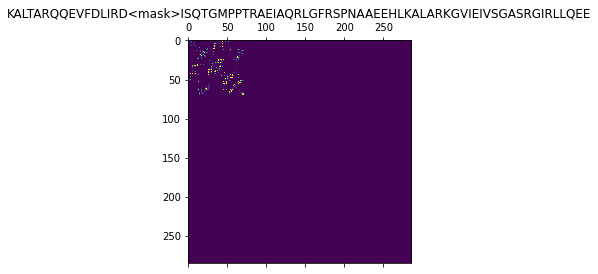

torch.Size([286, 286])


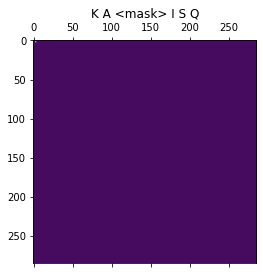

torch.Size([286, 286])


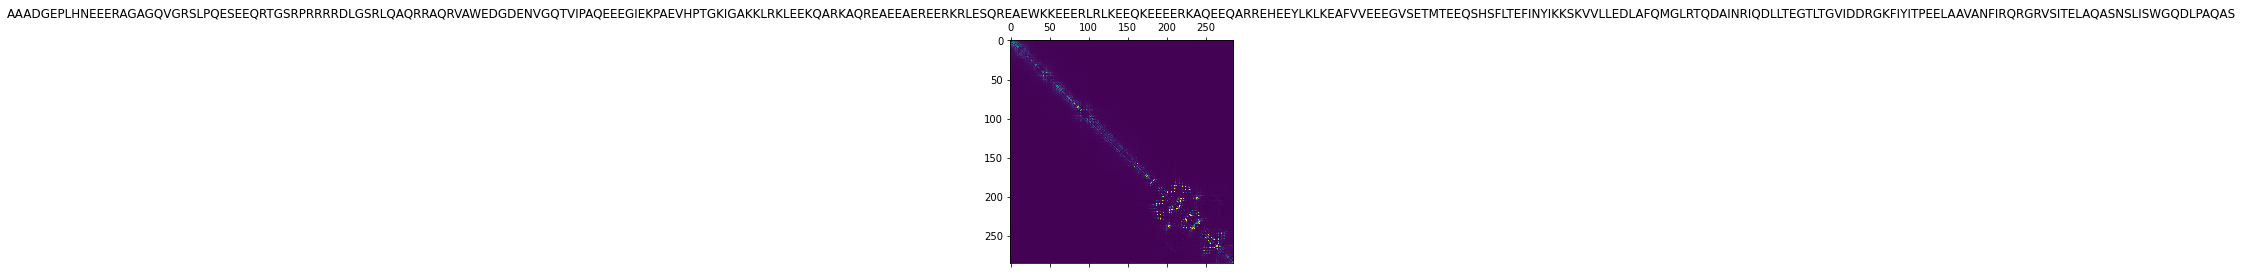

In [8]:
# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    #plt.matshow(attention_contacts[: len(seq), : len(seq)])
    print(attention_contacts.shape)
    plt.matshow(attention_contacts[: , : ])
    plt.title(seq)
    plt.show()

In [9]:
print(results.keys())

dict_keys(['logits', 'representations', 'attentions', 'contacts'])


In [10]:
logits = results['representations']

In [11]:
print(logits[32].shape)

torch.Size([5, 288, 1280])


In [12]:
print(model)

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [13]:
print(alphabet)

## Sequence embedding

The paper suggest to average all the hidden states and come to an embedding for the sequence. That is definately the first thing that we can try, but we may be losing some important information. 

We first try this.

In [14]:
newdata = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
]

In [15]:
batch_labels, batch_strs, batch_tokens = batch_converter(newdata)

In [16]:
with torch.no_grad():
    newresults = model(batch_tokens, repr_layers=[32], return_contacts=True)
    
token_representations = newresults["representations"][32]

In [17]:
token_representations.shape

torch.Size([1, 67, 1280])

In [18]:
sequence_representations[0]

tensor([ 4.6987, -2.3694, -0.3084,  ..., -4.0112, -3.2634, -1.0328])

In [19]:
import pandas as pd

In [20]:
df_train = pd.read_csv("./proteindata/train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("./proteindata/train_updates_20220929.csv", index_col="seq_id")

In [21]:
df_train.shape

(31390, 4)

In [22]:
all_features_nan = df_train_updates.isnull().all("columns")

In [23]:
drop_indices = df_train_updates[all_features_nan].index

In [24]:
drop_indices

Int64Index([   69,    70,    71,    72,    73,    74,    75,    76,    77,
               78,
            ...
            29682, 29787, 29788, 29852, 29853, 30738, 30739, 30740, 30741,
            30742],
           dtype='int64', name='seq_id', length=2409)

In [25]:
df_train = df_train.drop(index=drop_indices)

In [26]:
df_train.shape

(28981, 4)

In [27]:
swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

In [28]:
data = df_train

In [29]:
data.shape

(28981, 4)

In [30]:
x = data['protein_sequence'].tolist()

In [31]:
y = data['tm'].tolist()

In [32]:
ph = data['pH'].tolist()

In [33]:
len(x), len(y), len(ph)

(28981, 28981, 28981)

## Cleaning the training data

I suspect that the protein length > 1000 would not be good for the model. Test data sequence is around 200 in length.
I also think the ESM model does not accept such long sequences. Not sure but I think max is 1024, need to check so we can filter the data and discard longer > 1024 size sequences.


Also filtering for very short sequences < 40... just arbitrary we can change

In [ ]:
import math
train_x = []
train_y = []
train_ph = []

for sequence, tm, pH in zip(x, y, ph):
    if math.isnan(pH):
        continue
    if len(sequence) >= 20 and len(sequence) <= 620:
        #if tm < 25 or tm >= 105:
        #    continue
        train_x.append(sequence)
        train_y.append(tm)
        train_ph.append(pH)

In [ ]:
x[1]

In [ ]:
y[1]

In [ ]:
ph[1]

In [ ]:
len(train_x), len(train_y), len(train_ph)

In [ ]:
sequence_lengths = [len(sequence) for sequence in x]

In [ ]:
sequence_lengths[0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
plt.hist(sequence_lengths, range = (0, 1000))

In [ ]:
plt.hist(sequence_lengths, range = (1000, 10000))

In [ ]:
plt.hist(sequence_lengths, range = (0, 100))

In [ ]:
len(train_x), len(train_y), len(train_ph)

In [ ]:
train_sequence_lengths = [len(sequence) for sequence in train_x]

In [ ]:
plt.hist(train_sequence_lengths)
plt.show()

In [ ]:
plt.hist(train_y,100)
plt.xlim([20, 100])
plt.show()

# New Split BEFORE STRATIFYING

In [ ]:
len(train_x), len(train_y), len(train_ph)

In [ ]:
train_x_ph = [[x, ph] for (x, ph) in zip(train_x, train_ph)]

In [ ]:
data_x_ph, data_y = train_x_ph, train_y

In [ ]:
from sklearn.model_selection import train_test_split
train_x_ph, test_x_ph, train_y, test_y = train_test_split(data_x_ph, data_y, test_size=0.015, random_state=42, shuffle = True)

In [ ]:
len(train_x_ph), len(train_y)

In [ ]:
len(test_x_ph), len(test_y)

In [ ]:
train_x = [x_ph[0] for x_ph in train_x_ph]

In [ ]:
train_ph = [x_ph[1] for x_ph in train_x_ph]

In [ ]:
test_x = [x_ph[0] for x_ph in test_x_ph]

In [ ]:
test_ph = [x_ph[1] for x_ph in test_x_ph]

In [ ]:
len(train_x), len(train_y), len(train_ph)

In [ ]:
len(test_x), len(test_y), len(test_ph)

In [ ]:
test_x[0]

# Stratifying on train dataset

In [ ]:
counts, bins = np.histogram(train_y, 110, range = (25, 135))

In [ ]:
for index, (count_, bin_) in enumerate(zip(counts, bins)):
    print(str(index) + ':' + str(bin_) + ':' + str(count_))

In [ ]:
maxCount = max(counts)
print(maxCount)

In [ ]:
train_repsToStratify = [] 
reps = 0
for x, y, pH in zip(train_x, train_y, train_ph):
    #if y < 20 or y >= 100:
    #    continue
    bin_index = int(1 * (y - 25))
    bin_count = counts[bin_index]
    if bin_count == 0:
        train_repsToStratify.append(0)
    else:
        repToStratify = int((maxCount // bin_count) * 0.8) + 1
        print('y: ' + str(y) + ' counts: ' + str(bin_count) + ' reps to stratify: ' + str(repToStratify))
        train_repsToStratify.append(repToStratify)

In [ ]:
len(train_repsToStratify)

## Changing the sequence to embedding vector

First define a function..
averaging hidden states of the last layer... we may be losing some important information

In [ ]:
def ESMembedding(input_sequence):
    input_data = [("protein1", input_sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(input_data)
    batch_labels, batch_strs, batch_tokens = batch_labels, batch_strs, batch_tokens.cuda()
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]
    sequence_representations = token_representations[0, 1 : len(input_sequence) + 1].mean(0)
    return sequence_representations.cpu().numpy()

In [ ]:
model = model.cuda()

In [ ]:
test_embedding = ESMembedding(train_x[0])

In [ ]:
test_embedding

In [ ]:
len(test_embedding)

In [ ]:
ph_ = np.array(train_ph[0])

In [ ]:
ph_

In [ ]:
test_embedding = np.hstack([test_embedding, ph_])

In [ ]:
test_embedding

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Uncomment the lines in the below if you dont have save embeddings

In [ ]:
torch.cuda.memory_stats()

In [ ]:
torch.cuda.memory_summary()

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:4096'

In [ ]:
train_x_embed_stratified = []
train_y_stratified = []
train_ph_stratified = []

for i, (sequence, y, pH) in enumerate(zip(train_x, train_y, train_ph)):
    if i % 100 == 0:
        print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    for reps in range(train_repsToStratify[i]):
        train_x_embed_stratified.append(embed)
        train_y_stratified.append(y)
        train_ph_stratified.append(pH)

In [ ]:
len(test_x), len(test_y), len(test_ph)
test_x_embed = []

for i, (sequence) in enumerate(test_x):
    if i % 100 == 0:
        print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    test_x_embed.append(embed)
    

### Including pH as a scaled feature

In [ ]:
len(train_x_embed_stratified)

In [ ]:
len(test_x_embed)

In [ ]:
train_x_embed_stratified[0].shape

In [ ]:
len(train_x_embed_stratified)

In [ ]:
train_x_embed_stratified_new = [x.reshape([1, -1]) for x in train_x_embed_stratified]

In [ ]:
test_x_embed_new = [x.reshape([1, -1]) for x in test_x_embed]

In [ ]:
train_x_embed_stratified_new2 = np.vstack(train_x_embed_stratified_new)

In [ ]:
test_x_embed_new2 = np.vstack(test_x_embed_new)

In [ ]:
train_x_embed_stratified_new2.shape

In [ ]:
test_x_embed_new2.shape

In [ ]:
#This is not needed anymore after dataset fix

#import math

#average_pH = np.nanmean(np.array(train_ph_stratified))
#print(average_pH)

#count = 0

#for index, p in enumerate(train_ph_stratified):
#    if math.isnan(p):
#        train_ph_stratified[index] = average_pH

In [ ]:
plt.hist(train_y_stratified,100)
plt.xlim([25, 125])
plt.show()

In [ ]:
print(len(train_x))
print(len(train_y))
print(len(train_ph))

In [ ]:
print(len(train_x_embed_stratified))
print(len(train_y_stratified))
print(len(train_ph_stratified))

In [ ]:
train_ph_stratified_list = np.array(train_ph_stratified).reshape([-1, 1])

In [ ]:
test_ph_list = np.array(test_ph).reshape([-1, 1])

In [ ]:
train_ph_stratified_list.shape

In [ ]:
test_ph_list.shape

In [ ]:
train_ph_stratified_np_normalized = train_ph_stratified_list / 14

In [ ]:
test_ph_np_normalized = test_ph_list / 14

In [ ]:
train_x_embed_stratified_with_ph = np.hstack([train_x_embed_stratified_new2, train_ph_stratified_np_normalized])

In [ ]:
test_x_embed_with_ph = np.hstack([test_x_embed_new2, test_ph_np_normalized])

In [ ]:
train_x_embed_stratified_with_ph.shape

In [ ]:
test_x_embed_with_ph.shape

In [ ]:
train_x_embed_stratified_with_ph[112]

In [ ]:
test_x_embed_with_ph[112]

In [ ]:
X_test = test_x_embed_with_ph

In [ ]:
y_test = test_y

In [ ]:
X_train = train_x_embed_stratified_with_ph

In [ ]:
y_train = train_y_stratified

In [ ]:
len(X_train), len(y_train)

In [ ]:
len(X_test), len(y_test)

In [ ]:
# No longer needed as spliting stratified is not a good idea!
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(train_x_embed_stratified_with_ph, train_y_stratified, test_size=0.01, random_state=42, shuffle = True)

## Some memory clean up to help training steps

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [ ]:
del data
del df_train
del sequence_lengths
del ph
del df_train_updates
del data_x_ph
del data_y

del train_sequence_lengths
del train_repsToStratify
del train_x_ph
del train_y
del train_x
del train_x_embed_stratified_with_ph
del train_x_embed_stratified_new2
del train_x_embed_stratified_new
del train_x_embed_stratified
del train_ph_stratified
del train_ph_stratified_np_normalized
del train_ph
del train_y_stratified

del test_ph_np_normalized
del test_x_embed_with_ph
del test_x_embed_new2
del test_y




# Saving and/or loading all training and test data

### Save

In [ ]:
import pickle

In [ ]:
with open("X_train_1p5percentTest.pl", "wb") as fp:   
    pickle.dump(X_train, fp)

In [ ]:
with open("y_train_1p5percentTest.pl", "wb") as fp:   
    pickle.dump(y_train, fp)

In [ ]:
with open("X_test_1p5percentTest.pl", "wb") as fp:   
    pickle.dump(X_test, fp)

In [ ]:
with open("y_test_1p5percentTest.pl", "wb") as fp:   
    pickle.dump(y_test, fp)

## Load

In [34]:
import pickle

In [35]:
with open("X_train_1p5percentTest.pl", "rb") as fp:
    X_train = pickle.load(fp)

In [36]:
with open("y_train_1p5percentTest.pl", "rb") as fp:
    y_train = pickle.load(fp)

In [37]:
with open("X_test_1p5percentTest.pl", "rb") as fp:
    X_test = pickle.load(fp)

In [38]:
with open("y_test_1p5percentTest.pl", "rb") as fp:
    y_test = pickle.load(fp)

## Things to try first:
- GBM
- Random forrest
- kNN regression

In [39]:
X_train.shape

(77163, 1281)

In [40]:
X_train[0]

array([-0.00101669, -0.06467147,  0.01683933, ...,  0.04582359,
        0.13494533,  0.5       ])

In [41]:
from sklearn.neighbors import KNeighborsRegressor
kNN = KNeighborsRegressor(n_neighbors = 10, weights = 'uniform')
kNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [42]:
y_test_hat = kNN.predict(X_test)

In [43]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, y_test_hat)

print(MSE ** 0.5)

9.421454758693846


In [44]:
print(y_test_hat[:20])

[49.78 62.63 47.64 49.   39.09 52.08 47.94 54.13 52.72 44.16 35.99 50.67
 57.61 73.5  53.01 45.95 40.86 94.2  66.4  60.83]


In [45]:
print(y_test[:20])

[52.4, 65.9, 45.9, 41.6, 44.1, 49.0, 45.7, 42.0, 52.6, 56.0, 35.7, 39.9, 49.0, 67.4, 52.1, 43.7, 55.6, 88.8, 83.2, 55.5]


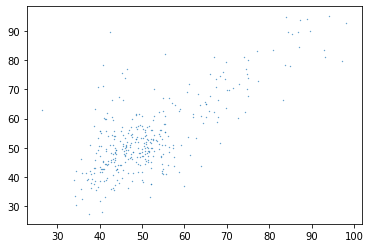

In [46]:
import matplotlib.pyplot as plt


plt.scatter(y_test, y_test_hat, s = .1)
plt.show()

In [47]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

corr, _ = pearsonr(y_test, y_test_hat)
print('Pearsons correlation: %.3f' % corr)

r2_score_ = r2_score(y_test, y_test_hat)
print('r2 score: %.3f' % r2_score_)

Pearsons correlation: 0.738
r2 score: 0.424


# Pytorch

In [118]:
import torch
from torch import nn
from torch import optim

#input_dim = 1281
input_dim = 1281 * 2

hidden_dim = 1024
hidden_dim2 = 256
hidden_dim3 = 64

output_dim = 1

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_uniform_(self.fc1.weight)
        #self.norm1 = nn.BatchNorm1d(hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        nn.init.xavier_uniform_(self.fc2.weight)
        #self.norm2 = nn.BatchNorm1d(hidden_dim2)
        
        #self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim2, output_dim)
        nn.init.xavier_uniform_(self.fc4.weight)
        
        self.sigmoid = nn.Sigmoid()
       
    def forward(self, x):
        #x = torch.nn.functional.relu(self.norm1(self.fc1(x)))
        x = torch.nn.functional.relu(self.fc1(x))
        
        x = torch.nn.functional.relu(self.fc2(x))
        
        #x = self.fc3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)

        return x
       
modelnn = Net(input_dim, hidden_dim, output_dim)
print(modelnn)

Net(
  (fc1): Linear(in_features=2562, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [387]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Available device: " + device)
device = torch.device(device)
modelnn = modelnn.to(device)
learning_rate = 0.00005
#loss_fn = nn.HuberLoss(reduction='sum', delta=0.1)
loss_fn = nn.BCELoss()
#loss_fn = nn.MarginRankingLoss()

optimizer = torch.optim.Adam(modelnn.parameters(), lr=learning_rate)

loss_fn = loss_fn.to(device)
print(device)

Available device: cuda:0
cuda:0


In [120]:
import random

In [121]:
%autosave 0

Autosave disabled


In [122]:
#modelnn.load_state_dict(torch.load('DualLoopModel_AlwaysRandomize'))

In [123]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [124]:
class DataFromTorch(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [125]:
X_train.shape

(77163, 1281)

In [126]:
len(y_train)

77163

In [127]:
y_train_np = np.array(y_train)

In [128]:
y_train_np_normalized = y_train_np / 100

In [129]:
y_train_np_normalized.shape

(77163,)

In [130]:
X_train_torch = torch.from_numpy(X_train.astype(np.float32)).to(device)

In [131]:
y_train_torch = torch.from_numpy(y_train_np_normalized.astype(np.float32)).to(device)

In [132]:
class DataFromTorch(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [133]:
batch_size = 512

In [134]:
train_data = DataFromTorch(X_train_torch, y_train_torch)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [135]:
X_train_torch.shape

torch.Size([77163, 1281])

In [136]:
y_train_torch.shape

torch.Size([77163])

In [137]:
y_train_torch[:10]

tensor([0.5590, 0.5590, 0.4260, 0.6260, 0.6260, 0.6260, 0.6260, 0.4690, 0.7140,
        0.7140], device='cuda:0')

In [138]:
device

device(type='cuda', index=0)

In [139]:
modelnn.to(device)

Net(
  (fc1): Linear(in_features=2562, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [140]:
#modelnn.load_state_dict(torch.load('HubertLoss_Layer33_CorrectSplit1p5percent100Epochs'))

In [389]:
print('starting the cell')
num_outer_epochs = 5000
num_epochs = 4
#loss_values = []
modelnn.train()


#SamplesPerTraining = 4
NumberTraings = X_train.shape[0]

print('Starting the outer loop...')
for outer_epoch in range(num_outer_epochs):
    
    Epoch_loss = 0
    
    for index, (X1, y1) in enumerate(train_dataloader):
        #print(X1.shape)
        #print(y1.shape)
        
        random_list = torch.randperm(X_train_torch.shape[0])[:X1.shape[0]]
        #print(random_list.shape)
        #print(random_list)
        X2 = X_train_torch[random_list]
        #print('X2 works and its shape is ' + str(X2.shape))
            
        X = torch.cat((X1, X2), 1)
        #print('X works and its shape is ' + str(X.shape))
            
        y2 = y_train_torch[random_list]
        #print('y2 works and its shape is ' + str(y2.shape))
        
        #print(y1)
        #print(y2)
        #print(y1.shape)
        #print(y2.shape)
        
        y = y2 > y1
        y = y.unsqueeze(-1).float().to(device)
            
        
        
        Batch_loss = 0
        
        for epoch in range(num_epochs):
            
            optimizer.zero_grad()
            pred = modelnn(X)
            #y    = (y1-y2).unsqueeze(-1)
            loss = loss_fn(pred, y)
            Batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            
        
        Epoch_loss += Batch_loss
        #print('Batch: ' + str(index) + '\t Loss: ' + str(Batch_loss))
            
    print('Epoch: ' + str(outer_epoch) + '\t Loss: ' + str(Epoch_loss / num_epochs))   

starting the cell
Starting the outer loop...
Epoch: 0	 Loss: 13.500870921183378
Epoch: 1	 Loss: 13.62527939118445
Epoch: 2	 Loss: 13.255673891399056
Epoch: 3	 Loss: 14.20319287898019
Epoch: 4	 Loss: 14.04377490002662
Epoch: 5	 Loss: 13.300186020787805
Epoch: 6	 Loss: 14.218664100859314
Epoch: 7	 Loss: 17.5292154061608
Epoch: 8	 Loss: 15.142961466219276
Epoch: 9	 Loss: 14.948675184044987
Epoch: 10	 Loss: 15.817527360282838
Epoch: 11	 Loss: 13.709184399805963
Epoch: 12	 Loss: 13.215278995689005
Epoch: 13	 Loss: 13.738318984862417
Epoch: 14	 Loss: 16.745401114225388
Epoch: 15	 Loss: 16.005654622334987
Epoch: 16	 Loss: 15.218432880472392
Epoch: 17	 Loss: 14.06576464138925
Epoch: 18	 Loss: 13.88156856270507
Epoch: 19	 Loss: 14.459606844931841
Epoch: 20	 Loss: 15.766786396503448
Epoch: 21	 Loss: 15.731243898160756
Epoch: 22	 Loss: 13.509105467237532
Epoch: 23	 Loss: 13.674241253174841
Epoch: 24	 Loss: 14.907519669272006
Epoch: 25	 Loss: 14.924513926263899
Epoch: 26	 Loss: 15.409397471230477


Epoch: 225	 Loss: 14.109873443376273
Epoch: 226	 Loss: 14.041940029710531
Epoch: 227	 Loss: 15.456553674302995
Epoch: 228	 Loss: 13.546402215957642
Epoch: 229	 Loss: 13.822496174834669
Epoch: 230	 Loss: 14.873671931680292
Epoch: 231	 Loss: 13.68973883986473
Epoch: 232	 Loss: 13.49966739071533
Epoch: 233	 Loss: 16.301474935840815
Epoch: 234	 Loss: 13.644523749593645
Epoch: 235	 Loss: 13.382077686488628
Epoch: 236	 Loss: 15.846485165413469
Epoch: 237	 Loss: 13.976665357593447
Epoch: 238	 Loss: 14.089146075770259
Epoch: 239	 Loss: 16.048325289506465
Epoch: 240	 Loss: 15.430459030438215
Epoch: 241	 Loss: 14.207085469271988
Epoch: 242	 Loss: 12.290824164636433
Epoch: 243	 Loss: 14.759298950433731
Epoch: 244	 Loss: 13.211288126651198
Epoch: 245	 Loss: 12.855067328549922
Epoch: 246	 Loss: 15.952944407239556
Epoch: 247	 Loss: 13.622596602886915
Epoch: 248	 Loss: 14.428451067768037
Epoch: 249	 Loss: 13.141918807290494
Epoch: 250	 Loss: 15.311238465365022
Epoch: 251	 Loss: 13.046898396220058
Epo

Epoch: 448	 Loss: 15.937147681135684
Epoch: 449	 Loss: 13.532397157978266
Epoch: 450	 Loss: 14.559410005342215
Epoch: 451	 Loss: 14.187543292995542
Epoch: 452	 Loss: 16.482346836477518
Epoch: 453	 Loss: 15.41022531175986
Epoch: 454	 Loss: 15.189642082899809
Epoch: 455	 Loss: 12.967518425546587
Epoch: 456	 Loss: 15.620546891819686
Epoch: 457	 Loss: 14.836400961969048
Epoch: 458	 Loss: 15.35143035557121
Epoch: 459	 Loss: 14.141603257972747
Epoch: 460	 Loss: 13.763343634549528
Epoch: 461	 Loss: 15.523980908095837
Epoch: 462	 Loss: 15.526038265787065
Epoch: 463	 Loss: 13.660602173302323
Epoch: 464	 Loss: 14.412172014359385
Epoch: 465	 Loss: 14.429905630182475
Epoch: 466	 Loss: 16.417547998018563
Epoch: 467	 Loss: 11.170145504176617
Epoch: 468	 Loss: 13.658825831022114
Epoch: 469	 Loss: 14.178948868997395
Epoch: 470	 Loss: 15.839558930601925
Epoch: 471	 Loss: 13.80252224067226
Epoch: 472	 Loss: 14.093350051902235
Epoch: 473	 Loss: 14.032582196872681
Epoch: 474	 Loss: 14.301653637550771
Epoc

Epoch: 671	 Loss: 12.876753829885274
Epoch: 672	 Loss: 13.310011250898242
Epoch: 673	 Loss: 14.488772237673402
Epoch: 674	 Loss: 15.36306646419689
Epoch: 675	 Loss: 13.064632226713002
Epoch: 676	 Loss: 13.50935874087736
Epoch: 677	 Loss: 14.529938836582005
Epoch: 678	 Loss: 13.412202659063041
Epoch: 679	 Loss: 14.45403861766681
Epoch: 680	 Loss: 13.749593443237245
Epoch: 681	 Loss: 14.972698984201998
Epoch: 682	 Loss: 14.36797128804028
Epoch: 683	 Loss: 14.864944401662797
Epoch: 684	 Loss: 16.938286594115198
Epoch: 685	 Loss: 15.432869696523994
Epoch: 686	 Loss: 14.023904820438474
Epoch: 687	 Loss: 14.053681708406657
Epoch: 688	 Loss: 16.1330365142785
Epoch: 689	 Loss: 16.58481354918331
Epoch: 690	 Loss: 13.935599979013205
Epoch: 691	 Loss: 11.847898582462221
Epoch: 692	 Loss: 13.90853437082842
Epoch: 693	 Loss: 12.763881133403629
Epoch: 694	 Loss: 13.890319577418268
Epoch: 695	 Loss: 14.149183865636587
Epoch: 696	 Loss: 15.484002478886396
Epoch: 697	 Loss: 14.636391399428248
Epoch: 69

Epoch: 894	 Loss: 13.298099120147526
Epoch: 895	 Loss: 16.97032605856657
Epoch: 896	 Loss: 15.818533424753696
Epoch: 897	 Loss: 14.190466559492052
Epoch: 898	 Loss: 12.673146522138268
Epoch: 899	 Loss: 13.696427493356168
Epoch: 900	 Loss: 12.431927585974336
Epoch: 901	 Loss: 13.790260985027999
Epoch: 902	 Loss: 14.113304885104299
Epoch: 903	 Loss: 13.700733118224889
Epoch: 904	 Loss: 13.124833778943866
Epoch: 905	 Loss: 14.065630552358925
Epoch: 906	 Loss: 13.159129716455936
Epoch: 907	 Loss: 13.851139633450657
Epoch: 908	 Loss: 13.956096884794533
Epoch: 909	 Loss: 12.88316043606028
Epoch: 910	 Loss: 15.269529694225639
Epoch: 911	 Loss: 13.665024552959949
Epoch: 912	 Loss: 13.441032277885824
Epoch: 913	 Loss: 12.352198139764369
Epoch: 914	 Loss: 12.874513624235988
Epoch: 915	 Loss: 13.074059156468138
Epoch: 916	 Loss: 13.674785181414336
Epoch: 917	 Loss: 13.609438562765718
Epoch: 918	 Loss: 13.339163286611438
Epoch: 919	 Loss: 13.727388333994895
Epoch: 920	 Loss: 13.71153124794364
Epoc

Epoch: 1114	 Loss: 12.404742733575404
Epoch: 1115	 Loss: 13.906829679850489
Epoch: 1116	 Loss: 14.897578929550946
Epoch: 1117	 Loss: 15.42813449492678
Epoch: 1118	 Loss: 15.403338896576315
Epoch: 1119	 Loss: 13.18535416200757
Epoch: 1120	 Loss: 14.1483531803824
Epoch: 1121	 Loss: 12.664445635396987
Epoch: 1122	 Loss: 11.907053822185844
Epoch: 1123	 Loss: 14.689476950094104
Epoch: 1124	 Loss: 13.758273353334516
Epoch: 1125	 Loss: 14.161679756361991
Epoch: 1126	 Loss: 14.999750925693661
Epoch: 1127	 Loss: 14.558815591968596
Epoch: 1128	 Loss: 12.459538377821445
Epoch: 1129	 Loss: 14.397601122036576
Epoch: 1130	 Loss: 14.043170457240194
Epoch: 1131	 Loss: 15.043485302478075
Epoch: 1132	 Loss: 14.710604851599783
Epoch: 1133	 Loss: 16.0399910248816
Epoch: 1134	 Loss: 15.77600516192615
Epoch: 1135	 Loss: 14.512522257864475
Epoch: 1136	 Loss: 13.352637914475054
Epoch: 1137	 Loss: 14.618718184996396
Epoch: 1138	 Loss: 15.029672839678824
Epoch: 1139	 Loss: 15.899815534241498
Epoch: 1140	 Loss: 

Epoch: 1331	 Loss: 15.245152852497995
Epoch: 1332	 Loss: 14.374926984775811
Epoch: 1333	 Loss: 15.284580006729811
Epoch: 1334	 Loss: 14.688295583240688
Epoch: 1335	 Loss: 15.462770418729633
Epoch: 1336	 Loss: 12.588039161171764
Epoch: 1337	 Loss: 13.489801562391222
Epoch: 1338	 Loss: 14.668302131351084
Epoch: 1339	 Loss: 15.422847795765847
Epoch: 1340	 Loss: 14.039885845035315
Epoch: 1341	 Loss: 12.596350726205856
Epoch: 1342	 Loss: 14.86499736411497
Epoch: 1343	 Loss: 14.103412494063377
Epoch: 1344	 Loss: 12.243662436492741
Epoch: 1345	 Loss: 13.311575099825859
Epoch: 1346	 Loss: 15.300724433735013
Epoch: 1347	 Loss: 14.133274747990072
Epoch: 1348	 Loss: 13.503771474584937
Epoch: 1349	 Loss: 12.569538126233965
Epoch: 1350	 Loss: 14.207084036897868
Epoch: 1351	 Loss: 14.547645470127463
Epoch: 1352	 Loss: 13.700427517760545
Epoch: 1353	 Loss: 15.321662162430584
Epoch: 1354	 Loss: 15.429140747524798
Epoch: 1355	 Loss: 12.760911700315773
Epoch: 1356	 Loss: 12.699764117598534
Epoch: 1357	 

Epoch: 1548	 Loss: 13.958065596874803
Epoch: 1549	 Loss: 14.829589864704758
Epoch: 1550	 Loss: 13.682701054494828
Epoch: 1551	 Loss: 14.205959086772054
Epoch: 1552	 Loss: 11.72482732962817
Epoch: 1553	 Loss: 11.950074132997543
Epoch: 1554	 Loss: 13.247790951747447
Epoch: 1555	 Loss: 12.438277618028224
Epoch: 1556	 Loss: 14.98792971484363
Epoch: 1557	 Loss: 16.40562102943659
Epoch: 1558	 Loss: 14.402981682680547
Epoch: 1559	 Loss: 13.92305366229266
Epoch: 1560	 Loss: 14.7098079463467
Epoch: 1561	 Loss: 14.145066851750016
Epoch: 1562	 Loss: 13.62358503555879
Epoch: 1563	 Loss: 15.425725978333503
Epoch: 1564	 Loss: 13.247322231531143
Epoch: 1565	 Loss: 13.100915600545704
Epoch: 1566	 Loss: 13.747507062740624
Epoch: 1567	 Loss: 14.43521605990827
Epoch: 1568	 Loss: 14.17609929991886
Epoch: 1569	 Loss: 13.211977336090058
Epoch: 1570	 Loss: 13.469397738575935
Epoch: 1571	 Loss: 14.760258091147989
Epoch: 1572	 Loss: 13.342646952252835
Epoch: 1573	 Loss: 14.128984740003943
Epoch: 1574	 Loss: 14

Epoch: 1766	 Loss: 12.618461892940104
Epoch: 1767	 Loss: 13.754523055627942
Epoch: 1768	 Loss: 14.443672637920827
Epoch: 1769	 Loss: 16.199904908891767
Epoch: 1770	 Loss: 13.621664627455175
Epoch: 1771	 Loss: 14.982683070935309
Epoch: 1772	 Loss: 13.641589409671724
Epoch: 1773	 Loss: 15.199934515170753
Epoch: 1774	 Loss: 14.137598084285855
Epoch: 1775	 Loss: 12.510264690499753
Epoch: 1776	 Loss: 12.741807535290718
Epoch: 1777	 Loss: 12.841059021651745
Epoch: 1778	 Loss: 13.625693874899298
Epoch: 1779	 Loss: 14.195826007053256
Epoch: 1780	 Loss: 13.607933420222253
Epoch: 1781	 Loss: 12.879771576728672
Epoch: 1782	 Loss: 13.387948723975569
Epoch: 1783	 Loss: 15.548608024138957
Epoch: 1784	 Loss: 14.79831624822691
Epoch: 1785	 Loss: 14.93103945394978
Epoch: 1786	 Loss: 13.867012667935342
Epoch: 1787	 Loss: 13.049377711489797
Epoch: 1788	 Loss: 15.223399839829654
Epoch: 1789	 Loss: 14.271614129189402
Epoch: 1790	 Loss: 13.747157926205546
Epoch: 1791	 Loss: 12.91484837885946
Epoch: 1792	 Lo

Epoch: 1983	 Loss: 15.251538489945233
Epoch: 1984	 Loss: 16.296195172239095
Epoch: 1985	 Loss: 14.2440134473145
Epoch: 1986	 Loss: 14.640865282621235
Epoch: 1987	 Loss: 14.570165489334613
Epoch: 1988	 Loss: 13.947268329095095
Epoch: 1989	 Loss: 14.080253170337528
Epoch: 1990	 Loss: 13.478216460440308
Epoch: 1991	 Loss: 12.930446561425924
Epoch: 1992	 Loss: 11.760469179600477
Epoch: 1993	 Loss: 13.748455478344113
Epoch: 1994	 Loss: 14.38652062928304
Epoch: 1995	 Loss: 11.881928445305675
Epoch: 1996	 Loss: 12.722265883814543
Epoch: 1997	 Loss: 13.351612260565162
Epoch: 1998	 Loss: 14.449568222742528
Epoch: 1999	 Loss: 14.898436640854925
Epoch: 2000	 Loss: 12.727788058109581
Epoch: 2001	 Loss: 14.175921243149787
Epoch: 2002	 Loss: 13.687377812340856
Epoch: 2003	 Loss: 13.367185495328158
Epoch: 2004	 Loss: 11.064815193414688
Epoch: 2005	 Loss: 15.135153314098716
Epoch: 2006	 Loss: 14.654973440337926
Epoch: 2007	 Loss: 15.552048265002668
Epoch: 2008	 Loss: 13.020288171013817
Epoch: 2009	 Lo

Epoch: 2200	 Loss: 16.58790315873921
Epoch: 2201	 Loss: 11.876259338576347
Epoch: 2202	 Loss: 13.812559271696955
Epoch: 2203	 Loss: 13.455836798530072
Epoch: 2204	 Loss: 12.468124283477664
Epoch: 2205	 Loss: 13.388550487812608
Epoch: 2206	 Loss: 14.258648573420942
Epoch: 2207	 Loss: 15.881218097172678
Epoch: 2208	 Loss: 13.043393933679909
Epoch: 2209	 Loss: 16.375442730728537
Epoch: 2210	 Loss: 10.152379693463445
Epoch: 2211	 Loss: 14.290360162500292
Epoch: 2212	 Loss: 13.86675321124494
Epoch: 2213	 Loss: 13.919081688392907
Epoch: 2214	 Loss: 13.459623557515442
Epoch: 2215	 Loss: 14.43591939797625
Epoch: 2216	 Loss: 13.18744657561183
Epoch: 2217	 Loss: 14.781551912426949
Epoch: 2218	 Loss: 13.539835037663579
Epoch: 2219	 Loss: 14.360826664604247
Epoch: 2220	 Loss: 13.282387275714427
Epoch: 2221	 Loss: 12.894595943856984
Epoch: 2222	 Loss: 13.542871091049165
Epoch: 2223	 Loss: 12.492600252386183
Epoch: 2224	 Loss: 15.272385166957974
Epoch: 2225	 Loss: 13.716360586229712
Epoch: 2226	 Los

Epoch: 2417	 Loss: 14.074346573557705
Epoch: 2418	 Loss: 15.097153776325285
Epoch: 2419	 Loss: 12.917038377840072
Epoch: 2420	 Loss: 15.27836029464379
Epoch: 2421	 Loss: 13.80940786935389
Epoch: 2422	 Loss: 13.170191435143352
Epoch: 2423	 Loss: 14.39839433412999
Epoch: 2424	 Loss: 14.261226342059672
Epoch: 2425	 Loss: 11.533046540804207
Epoch: 2426	 Loss: 13.277261442039162
Epoch: 2427	 Loss: 13.322768927551806
Epoch: 2428	 Loss: 13.90310152573511
Epoch: 2429	 Loss: 11.880143319256604
Epoch: 2430	 Loss: 15.540638135746121
Epoch: 2431	 Loss: 13.838214749004692
Epoch: 2432	 Loss: 13.982330804225057
Epoch: 2433	 Loss: 13.990214297547936
Epoch: 2434	 Loss: 12.961521956138313
Epoch: 2435	 Loss: 13.456562891602516
Epoch: 2436	 Loss: 16.172480570152402
Epoch: 2437	 Loss: 14.046179013792425
Epoch: 2438	 Loss: 13.436470930464566
Epoch: 2439	 Loss: 15.073040981777012
Epoch: 2440	 Loss: 10.60759217850864
Epoch: 2441	 Loss: 12.980178105644882
Epoch: 2442	 Loss: 13.525893303565681
Epoch: 2443	 Loss

Epoch: 2634	 Loss: 15.13910375861451
Epoch: 2635	 Loss: 14.721273727715015
Epoch: 2636	 Loss: 13.63385645719245
Epoch: 2637	 Loss: 11.944702456239611
Epoch: 2638	 Loss: 12.864050761796534
Epoch: 2639	 Loss: 14.369045155588537
Epoch: 2640	 Loss: 14.620853321626782
Epoch: 2641	 Loss: 13.394681530073285
Epoch: 2642	 Loss: 13.982960987370461
Epoch: 2643	 Loss: 13.978310819715261
Epoch: 2644	 Loss: 13.801948300097138
Epoch: 2645	 Loss: 13.142118738498539
Epoch: 2646	 Loss: 12.891591691412032
Epoch: 2647	 Loss: 12.430731140542775
Epoch: 2648	 Loss: 13.598450949415565
Epoch: 2649	 Loss: 13.591748376376927
Epoch: 2650	 Loss: 13.642935663461685
Epoch: 2651	 Loss: 12.274808909278363
Epoch: 2652	 Loss: 12.723812312353402
Epoch: 2653	 Loss: 14.241137096658349
Epoch: 2654	 Loss: 14.18340900586918
Epoch: 2655	 Loss: 15.199301505926996
Epoch: 2656	 Loss: 13.040054371580482
Epoch: 2657	 Loss: 14.360314700752497
Epoch: 2658	 Loss: 14.90890399320051
Epoch: 2659	 Loss: 15.654872295446694
Epoch: 2660	 Los

Epoch: 2851	 Loss: 13.015315647237003
Epoch: 2852	 Loss: 14.233719341922551
Epoch: 2853	 Loss: 11.952133010141551
Epoch: 2854	 Loss: 14.577564713545144
Epoch: 2855	 Loss: 13.227755276020616
Epoch: 2856	 Loss: 13.904559074435383
Epoch: 2857	 Loss: 13.175463833846152
Epoch: 2858	 Loss: 15.701592907775193
Epoch: 2859	 Loss: 11.306063628289849
Epoch: 2860	 Loss: 11.563168249558657
Epoch: 2861	 Loss: 14.153761812485754
Epoch: 2862	 Loss: 15.555804608855397
Epoch: 2863	 Loss: 14.814660659525543
Epoch: 2864	 Loss: 13.287238606251776
Epoch: 2865	 Loss: 13.494459231384099
Epoch: 2866	 Loss: 13.568091417197138
Epoch: 2867	 Loss: 14.989739412907511
Epoch: 2868	 Loss: 14.587354042101651
Epoch: 2869	 Loss: 12.943463003262877
Epoch: 2870	 Loss: 13.34213542426005
Epoch: 2871	 Loss: 11.95253582065925
Epoch: 2872	 Loss: 12.050138928927481
Epoch: 2873	 Loss: 14.31670154677704
Epoch: 2874	 Loss: 13.218331168405712
Epoch: 2875	 Loss: 14.947746990714222
Epoch: 2876	 Loss: 15.172688617371023
Epoch: 2877	 Lo

Epoch: 3068	 Loss: 14.144474458415061
Epoch: 3069	 Loss: 16.205120320431888
Epoch: 3070	 Loss: 14.530885607935488
Epoch: 3071	 Loss: 14.870179274585098
Epoch: 3072	 Loss: 13.446919889189303
Epoch: 3073	 Loss: 15.436076995451003
Epoch: 3074	 Loss: 13.246851564850658
Epoch: 3075	 Loss: 14.73678638227284
Epoch: 3076	 Loss: 15.757840673439205
Epoch: 3077	 Loss: 13.343625388108194
Epoch: 3078	 Loss: 12.619093360845
Epoch: 3079	 Loss: 13.525041137356311
Epoch: 3080	 Loss: 14.33910367777571
Epoch: 3081	 Loss: 12.532367949839681
Epoch: 3082	 Loss: 14.793530427850783
Epoch: 3083	 Loss: 14.666407896205783
Epoch: 3084	 Loss: 13.701165147125721
Epoch: 3085	 Loss: 13.931233516894281
Epoch: 3086	 Loss: 13.467289798427373
Epoch: 3087	 Loss: 13.082985780201852
Epoch: 3088	 Loss: 13.258940242230892
Epoch: 3089	 Loss: 14.614784582518041
Epoch: 3090	 Loss: 12.424879871774465
Epoch: 3091	 Loss: 15.065382651053369
Epoch: 3092	 Loss: 12.687051297631115
Epoch: 3093	 Loss: 13.980278794653714
Epoch: 3094	 Loss

Epoch: 3285	 Loss: 14.167605096939951
Epoch: 3286	 Loss: 17.277828214224428
Epoch: 3287	 Loss: 14.84844575356692
Epoch: 3288	 Loss: 14.066417853347957
Epoch: 3289	 Loss: 13.434983846265823
Epoch: 3290	 Loss: 14.973717865534127
Epoch: 3291	 Loss: 13.17775530507788
Epoch: 3292	 Loss: 13.833695694804192
Epoch: 3293	 Loss: 14.425286794546992
Epoch: 3294	 Loss: 12.782358673866838
Epoch: 3295	 Loss: 11.332933733705431
Epoch: 3296	 Loss: 13.980414889752865
Epoch: 3297	 Loss: 13.023421566467732
Epoch: 3298	 Loss: 13.10160104231909
Epoch: 3299	 Loss: 12.638970841187984
Epoch: 3300	 Loss: 11.06146047404036
Epoch: 3301	 Loss: 15.20235242554918
Epoch: 3302	 Loss: 12.005652950610965
Epoch: 3303	 Loss: 12.253694482147694
Epoch: 3304	 Loss: 13.382658208254725
Epoch: 3305	 Loss: 16.1167775625363
Epoch: 3306	 Loss: 15.813438036944717
Epoch: 3307	 Loss: 15.760747843887657
Epoch: 3308	 Loss: 12.849316900130361
Epoch: 3309	 Loss: 14.417492265813053
Epoch: 3310	 Loss: 13.610705714207143
Epoch: 3311	 Loss: 

Epoch: 3502	 Loss: 13.582872189115733
Epoch: 3503	 Loss: 14.084888678975403
Epoch: 3504	 Loss: 11.830006553325802
Epoch: 3505	 Loss: 16.127258685417473
Epoch: 3506	 Loss: 13.400852329097688
Epoch: 3507	 Loss: 14.329061951022595
Epoch: 3508	 Loss: 12.048270993866026
Epoch: 3509	 Loss: 13.442313133273274
Epoch: 3510	 Loss: 13.311186402570456
Epoch: 3511	 Loss: 15.115242440253496
Epoch: 3512	 Loss: 15.408727739471942
Epoch: 3513	 Loss: 14.260613574180752
Epoch: 3514	 Loss: 14.247347828000784
Epoch: 3515	 Loss: 13.247816844377667
Epoch: 3516	 Loss: 12.448489092290401
Epoch: 3517	 Loss: 14.176055788062513
Epoch: 3518	 Loss: 13.640029959380627
Epoch: 3519	 Loss: 13.995625022798777
Epoch: 3520	 Loss: 13.337042306549847
Epoch: 3521	 Loss: 12.344983007293195
Epoch: 3522	 Loss: 14.978138950187713
Epoch: 3523	 Loss: 13.580739122349769
Epoch: 3524	 Loss: 15.066517737694085
Epoch: 3525	 Loss: 13.489052350632846
Epoch: 3526	 Loss: 12.929259844589978
Epoch: 3527	 Loss: 10.969816690310836
Epoch: 3528	

Epoch: 3719	 Loss: 12.104257563129067
Epoch: 3720	 Loss: 12.783616468310356
Epoch: 3721	 Loss: 14.227180988062173
Epoch: 3722	 Loss: 13.136478299740702
Epoch: 3723	 Loss: 13.408207768574357
Epoch: 3724	 Loss: 12.714403432793915
Epoch: 3725	 Loss: 14.202671249397099
Epoch: 3726	 Loss: 14.987520525697619
Epoch: 3727	 Loss: 13.740013203583658
Epoch: 3728	 Loss: 11.182472307700664
Epoch: 3729	 Loss: 13.353916597086936
Epoch: 3730	 Loss: 12.339319656137377
Epoch: 3731	 Loss: 14.250059207901359
Epoch: 3732	 Loss: 12.161140815354884
Epoch: 3733	 Loss: 13.504655467811972
Epoch: 3734	 Loss: 14.126164936926216
Epoch: 3735	 Loss: 15.929813406430185
Epoch: 3736	 Loss: 12.56808218266815
Epoch: 3737	 Loss: 15.940166089683771
Epoch: 3738	 Loss: 12.720223222393543
Epoch: 3739	 Loss: 15.281974905636162
Epoch: 3740	 Loss: 15.881494162604213
Epoch: 3741	 Loss: 15.949975059833378
Epoch: 3742	 Loss: 13.348107791505754
Epoch: 3743	 Loss: 12.363020163495094
Epoch: 3744	 Loss: 13.088547751307487
Epoch: 3745	 

Epoch: 3936	 Loss: 12.315672399941832
Epoch: 3937	 Loss: 15.223433646839112
Epoch: 3938	 Loss: 13.778235505800694
Epoch: 3939	 Loss: 13.716045396402478
Epoch: 3940	 Loss: 14.360700962599367
Epoch: 3941	 Loss: 11.957580814138055
Epoch: 3942	 Loss: 13.673743728548288
Epoch: 3943	 Loss: 13.261197788175195
Epoch: 3944	 Loss: 14.378178376704454
Epoch: 3945	 Loss: 13.116905371192843
Epoch: 3946	 Loss: 13.216177681926638
Epoch: 3947	 Loss: 11.164592104963958
Epoch: 3948	 Loss: 15.473873985465616
Epoch: 3949	 Loss: 14.75271663395688
Epoch: 3950	 Loss: 14.119367555715144
Epoch: 3951	 Loss: 13.792276015970856
Epoch: 3952	 Loss: 14.273910453543067
Epoch: 3953	 Loss: 13.186148905660957
Epoch: 3954	 Loss: 13.871411912608892
Epoch: 3955	 Loss: 11.895727534778416
Epoch: 3956	 Loss: 13.847058025188744
Epoch: 3957	 Loss: 12.868584773968905
Epoch: 3958	 Loss: 15.694920943584293
Epoch: 3959	 Loss: 11.596572942100465
Epoch: 3960	 Loss: 13.947909499518573
Epoch: 3961	 Loss: 12.836905780248344
Epoch: 3962	 

Epoch: 4153	 Loss: 12.370496654883027
Epoch: 4154	 Loss: 12.89264958910644
Epoch: 4155	 Loss: 15.129851843696088
Epoch: 4156	 Loss: 13.760427424218506
Epoch: 4157	 Loss: 13.933048562146723
Epoch: 4158	 Loss: 13.067934157792479
Epoch: 4159	 Loss: 13.481130833737552
Epoch: 4160	 Loss: 13.470055758953094
Epoch: 4161	 Loss: 16.176525295246392
Epoch: 4162	 Loss: 13.118054818361998
Epoch: 4163	 Loss: 13.932849512435496
Epoch: 4164	 Loss: 14.34565810719505
Epoch: 4165	 Loss: 13.203380649443716
Epoch: 4166	 Loss: 14.132123791147023
Epoch: 4167	 Loss: 13.280933421105146
Epoch: 4168	 Loss: 13.874250816646963
Epoch: 4169	 Loss: 14.06711693201214
Epoch: 4170	 Loss: 13.253787907771766
Epoch: 4171	 Loss: 15.633062827866524
Epoch: 4172	 Loss: 13.284708367660642
Epoch: 4173	 Loss: 13.863113866653293
Epoch: 4174	 Loss: 13.993829666636884
Epoch: 4175	 Loss: 13.650389517657459
Epoch: 4176	 Loss: 12.752910512499511
Epoch: 4177	 Loss: 12.54555322509259
Epoch: 4178	 Loss: 13.707729498622939
Epoch: 4179	 Los

Epoch: 4370	 Loss: 12.677734000142664
Epoch: 4371	 Loss: 11.654253131709993
Epoch: 4372	 Loss: 11.65422999439761
Epoch: 4373	 Loss: 13.230722829233855
Epoch: 4374	 Loss: 12.154667594004422
Epoch: 4375	 Loss: 13.581555429380387
Epoch: 4376	 Loss: 13.255128445569426
Epoch: 4377	 Loss: 14.11239320365712
Epoch: 4378	 Loss: 14.524737322237343
Epoch: 4379	 Loss: 14.248232799582183
Epoch: 4380	 Loss: 12.602310535032302
Epoch: 4381	 Loss: 12.137464040424675
Epoch: 4382	 Loss: 13.974673419259489
Epoch: 4383	 Loss: 13.468992807902396
Epoch: 4384	 Loss: 12.960119426716119
Epoch: 4385	 Loss: 13.267490164376795
Epoch: 4386	 Loss: 12.7642742251046
Epoch: 4387	 Loss: 14.414950036909431
Epoch: 4388	 Loss: 14.300337359309196
Epoch: 4389	 Loss: 15.039016579277813
Epoch: 4390	 Loss: 13.868690262082964
Epoch: 4391	 Loss: 16.238109246827662
Epoch: 4392	 Loss: 11.399617253337055
Epoch: 4393	 Loss: 14.456851699389517
Epoch: 4394	 Loss: 13.83664270164445
Epoch: 4395	 Loss: 12.484921557828784
Epoch: 4396	 Loss

Epoch: 4587	 Loss: 14.838063572067767
Epoch: 4588	 Loss: 12.40569873386994
Epoch: 4589	 Loss: 13.35278761992231
Epoch: 4590	 Loss: 13.181611324194819
Epoch: 4591	 Loss: 14.68281332636252
Epoch: 4592	 Loss: 13.368345411494374
Epoch: 4593	 Loss: 14.490941694006324
Epoch: 4594	 Loss: 15.236570905894041
Epoch: 4595	 Loss: 13.58242542622611
Epoch: 4596	 Loss: 15.591456773225218
Epoch: 4597	 Loss: 13.33467076253146
Epoch: 4598	 Loss: 14.715101750101894
Epoch: 4599	 Loss: 12.943938401993364
Epoch: 4600	 Loss: 14.436911368742585
Epoch: 4601	 Loss: 15.363725048489869
Epoch: 4602	 Loss: 12.575519721955061
Epoch: 4603	 Loss: 13.9883379987441
Epoch: 4604	 Loss: 14.60119175678119
Epoch: 4605	 Loss: 15.627094214316458
Epoch: 4606	 Loss: 14.537222039420158
Epoch: 4607	 Loss: 12.554479076527059
Epoch: 4608	 Loss: 13.221817443147302
Epoch: 4609	 Loss: 11.14444121485576
Epoch: 4610	 Loss: 13.038905811496079
Epoch: 4611	 Loss: 12.28996896976605
Epoch: 4612	 Loss: 13.803003950510174
Epoch: 4613	 Loss: 13.

Epoch: 4805	 Loss: 13.316635787021369
Epoch: 4806	 Loss: 13.186013033147901
Epoch: 4807	 Loss: 12.38864631485194
Epoch: 4808	 Loss: 15.424043237697333
Epoch: 4809	 Loss: 14.152977579738945
Epoch: 4810	 Loss: 15.292782610747963
Epoch: 4811	 Loss: 11.978967518545687
Epoch: 4812	 Loss: 12.04793558223173
Epoch: 4813	 Loss: 12.138521493878216
Epoch: 4814	 Loss: 12.873151478823274
Epoch: 4815	 Loss: 13.803121073637158
Epoch: 4816	 Loss: 13.529595023952425
Epoch: 4817	 Loss: 13.670982010662556
Epoch: 4818	 Loss: 12.45756402425468
Epoch: 4819	 Loss: 15.504655081313103
Epoch: 4820	 Loss: 12.606625834014267
Epoch: 4821	 Loss: 13.803312905598432
Epoch: 4822	 Loss: 16.03362852241844
Epoch: 4823	 Loss: 15.1552967694588
Epoch: 4824	 Loss: 12.877469450235367
Epoch: 4825	 Loss: 13.84466040506959
Epoch: 4826	 Loss: 14.242241664789617
Epoch: 4827	 Loss: 13.324677141848952
Epoch: 4828	 Loss: 13.28183960961178
Epoch: 4829	 Loss: 14.52397526288405
Epoch: 4830	 Loss: 13.39584677759558
Epoch: 4831	 Loss: 14.

In [ ]:
y1

In [ ]:
y2.shape

In [ ]:
 y = y1 > y2

In [ ]:
y.shape

In [ ]:
y

In [390]:
#torch.save(modelnn.state_dict(), 'HubertLoss_Layer33_CorrectSplit1p5percent2000Epochs')
torch.save(modelnn.state_dict(), 'BCELoss_Layer33_CorrectSplit1p5percent6000Epochs')

In [ ]:
#modelnn.load_state_dict(torch.load('HubertLoss_Layer33_CorrectSplit1p5percent100Epochs'))

In [ ]:
X_train_torch.shape

In [ ]:
y_train_torch.shape

In [ ]:
X_test_torch = torch.from_numpy(X_test.astype(np.float32)).to(device)

In [ ]:
y_test[:5]

In [ ]:
y_test_np = np.array(y_test)
y_test_np_normalized = y_test_np / 100
y_test_torch = torch.from_numpy(y_test_np_normalized.astype(np.float32)).to(device)

In [ ]:
X_test_torch.shape, y_test_torch.shape

# Regression

In [ ]:
modelnn.eval()

In [ ]:
#modelnn.load_state_dict(torch.load('DualLoopModel_AlwaysRandomize3'))

## Regression based on making pairs with the entire train data

In [ ]:
def getDualRegressionFromEmbedding(embed):
    x_array = []
    y_array = []
    target_array = []
    #print(embed)
    
    preds = []
    preds_rev = []
    ys    = []
    for index, (X1, y1) in enumerate(train_dataloader):
        
        #print(X1)
        #print(X1.shape)
        #print(y1.shape)
        
        X2 = torch.from_numpy(embed.astype(np.float32)).to(device).unsqueeze(0).repeat(X1.shape[0], 1)
        #X2 = torch.from_numpy(embed.repeat(X1.shape[0]).reshape(X1.shape[0], -1).astype(np.float32)).to(device)
        #print('X2 works and its shape is ' + str(X2.shape))
        #print(X2)
        
            
        X = torch.cat((X1, X2), 1)
        X_rev = torch.cat((X2, X1), 1)
        
        #print('X works and its shape is ' + str(X.shape))
        #print(X)
        with torch.no_grad():
            pred = modelnn(X)
            pred_rev = modelnn(X_rev)
        
        #print('prediction success and shape of output ' + str(pred.shape))
        
        preds.append(pred)
        preds_rev.append(pred_rev)
        ys.append(y1)
        
        
        
    return torch.cat(preds, dim=0).detach().cpu().numpy(), torch.cat(preds_rev, dim=0).detach().cpu().numpy(), torch.cat(ys, dim=0).detach().cpu().numpy()
    

# Regression of difference based on comparing each embedding to test dataset

In [ ]:
def getDualRegressionFromTestEmbedding(index, embeddings):
    x_array = []
    y_array = []
    target_array = []
    #print(embed)
    embed = embeddings[index]
    preds = []
    preds_rev = []
    ys    = []
    for index_, x in enumerate(embeddings):
        
        if index == index_:
            continue
            
        x_array.append(np.array(x))
        target_array.append(embed)
        
        #print(X1)
        #print(X1.shape)
        #print(y1.shape)
        
    x_array = np.array(x_array)
            
    target_array = np.array(target_array)
        
    X_torch = torch.from_numpy(x_array.astype(np.float32))
    target_torch = torch.from_numpy(target_array.astype(np.float32))
        
    input_torch = torch.cat((target_torch, X_torch), 1).to(device)
    input_rev_torch = torch.cat((X_torch, target_torch), 1).to(device)
        
    with torch.no_grad():
        diff_array     = modelnn(input_torch).detach().cpu().numpy()
        diff_rev_array = modelnn(input_rev_torch).detach().cpu().numpy()
    
    estimates_array = 0.5 * diff_array - 0.5 * diff_rev_array 
    
    return estimates_array

# Regression based on comparing two embedding only
Using it to compare with wild

In [161]:
def compareTwo(embed1, embed2):
    x_array = []
    y_array = []
    target_array = []
    #print(embed1)
    #print(embed2)
    preds = []
    preds_rev = []
    ys    = []
            
    x_array.append(embed1)
    target_array.append(embed2)
        
        #print(X1)
        #print(X1.shape)
        #print(y1.shape)
        
    x_array = np.array(x_array)
    target_array = np.array(target_array)
        
    X_torch = torch.from_numpy(x_array.astype(np.float32))
    target_torch = torch.from_numpy(target_array.astype(np.float32))
        
    input_torch = torch.cat((target_torch, X_torch), 1).to(device)
    input_rev_torch = torch.cat((X_torch, target_torch), 1).to(device)
        
    with torch.no_grad():
        diff_array     = modelnn(input_torch).detach().cpu().numpy()
        diff_rev_array = modelnn(input_rev_torch).detach().cpu().numpy()
    
    estimates_array = -0.5 * diff_array + 0.5 * diff_rev_array 
    
    return estimates_array.squeeze()

### Testing compare two for both train data

In [193]:
index1 = 200 
index2 = 100
embd1 = X_train[index1]
embd2 = X_train[index2]


In [194]:
embd1, y_train_np_normalized[index1] * 100

(array([ 0.00202838, -0.16156815, -0.0032843 , ...,  0.12514734,
         0.14548051,  0.22857143]),
 59.20000000000001)

In [195]:
embd1, y_train_np_normalized[index2] * 100

(array([ 0.00202838, -0.16156815, -0.0032843 , ...,  0.12514734,
         0.14548051,  0.22857143]),
 66.4)

In [196]:
difference = compareTwo(embd1, embd2)

In [197]:
print(difference) #Estimates tm(embed2) - tm(embed1)
print(y_train_np_normalized[index2] * 100 - y_train_np_normalized[index1] * 100)

0.49692512
7.199999999999996


### Testing compare two for train data and test data

It seems it is a pretty good comparator at least!!!

In [198]:
index1 = 20 
index2 = 99
embd1 = X_test[index1]
embd2 = X_test[index2]

In [199]:
embd1, y_test[index1]

(array([ 0.01480815, -0.14729767, -0.05179141, ...,  0.02108314,
         0.05675289,  0.5       ]),
 49.2)

In [200]:
embd2, y_test[index2]

(array([ 0.08031445, -0.14920378, -0.01828247, ...,  0.04049026,
         0.01552572,  0.5       ]),
 84.8)

In [201]:
difference = compareTwo(embd1, embd2) #Estimates tm(embed2) - tm(embed1)
print(difference)
print(y_test[index2] - y_test[index1])

0.5
35.599999999999994


In [ ]:
torch.cuda.empty_cache() 

## Quick validation on train and test samples

### Train sample check

In [ ]:
index = 55
embd = X_train[index]
X_train[index], y_train_np_normalized[index] * 100

In [ ]:
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embd)

In [ ]:
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

In [ ]:
res.shape

In [ ]:
plt.hist(res,100)
#plt.xlim([25, 125])
plt.show()

In [ ]:
np.mean(res) * 100, np.median(res) * 100, np.std(res)

### Test sample check

In [ ]:
X_test.shape, len(y_test)

In [ ]:
y_test[:5]

In [ ]:
index = 18
embd = X_test[index]
X_test[index], y_test[index] 

In [ ]:
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embd)

In [ ]:
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

In [ ]:
res.shape

In [ ]:
plt.hist(res,100)
#plt.xlim([25, 125])
plt.show()

In [ ]:
np.mean(res) * 100, np.median(res) * 100, np.std(res)

## Complete Validation of test set

In [ ]:
X_test.shape, len(y_test)

In [ ]:
y_hat_test = []

for index, (test_embed, y) in enumerate(zip(X_test, y_test)):
    #print(test_embed)
    #print(y)
    diff, diff_rev, y_arr = getDualRegressionFromEmbedding(test_embed)
    estimates = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)
    print("{}: Mean {:.2f}, Median {:.2f}, std {:.2f}, truth {:.2f}".format(index, np.mean(estimates), np.median(estimates), np.std(estimates), y))
    y_hat_test.append([np.mean(estimates), np.median(estimates), np.std(estimates)])


In [ ]:
y_hat_test_means = [mean_median_std[0] * 100 for mean_median_std in y_hat_test]
y_hat_test_medians = [mean_median_std[1] * 100 for mean_median_std in y_hat_test]
y_hat_test_stds = [mean_median_std[2] * 100 for mean_median_std in y_hat_test]

In [ ]:
y_test[:5]

In [ ]:
y_hat_test_means[:5]

In [ ]:
MSE = mean_squared_error(y_test, y_hat_test_medians)

print(MSE ** 0.5)

In [ ]:
plt.scatter(y_test, y_test_hat, s = .1)
plt.show()

In [ ]:
corr, _ = pearsonr(y_test, y_test_hat)
print('Pearsons correlation: %.3f' % corr)

r2_score_ = r2_score(y_test, y_test_hat)
print('r2 score: %.3f' % r2_score_)

In [ ]:
plt.plot(y_hat_test_stds)

## Final Test before I give up.... Ranking the test dataset using compareTwo 

In [176]:
X_test[:5]

array([[-0.01001186, -0.04838194, -0.01936032, ..., -0.14082199,
         0.06385342,  0.5       ],
       [-0.01242851, -0.0778545 , -0.07832978, ...,  0.0159122 ,
         0.13577951,  0.5       ],
       [ 0.05590679, -0.0725912 , -0.02706128, ..., -0.01876969,
         0.05200453,  0.5       ],
       [ 0.02156408,  0.06545417,  0.09073136, ...,  0.06026006,
        -0.00139166,  0.5       ],
       [ 0.04061162, -0.04854408, -0.03491011, ..., -0.02572792,
         0.01974615,  0.5       ]])

In [391]:
testSet_model_bigger_than_ranks  = []
testSet_real_bigger_than_ranks = []
ranks_mismatch = []
modelnn.eval()

for index1, embed1 in enumerate(X_test):
    
    index1_bigger_than_model = 0
    index1_bigger_than_real = 0
    
    for index2, embed2 in enumerate(X_test):
        if index1 == index2:
            continue
        difference = compareTwo(embed1, embed2)  * 100 # if negative: embed1>embed2 and if positive embed1<embed2
        difference_real = y_test[index2] - y_test[index1]
        
        if difference > 0:
            #print("Index {} < Index {}".format(index1, index2))
            pass
        else:
            #print("Index {} > Index {}".format(index1, index2))
            index1_bigger_than_model += 1
        
        if difference_real > 0:
            #print("Index {} < Index {}".format(index1, index2))
            pass
        else:
            #print("Index {} > Index {}".format(index1, index2))
            index1_bigger_than_real += 1

    testSet_model_bigger_than_ranks.append(index1_bigger_than_model)
    testSet_real_bigger_than_ranks.append(index1_bigger_than_real)
    ranks_mismatch.append(np.abs(index1_bigger_than_real - index1_bigger_than_model))
    print("Index {} is bigger than: Model {}, Actual {} others".format(index1, index1_bigger_than_model, index1_bigger_than_real))

Index 0 is bigger than: Model 223, Actual 230 others
Index 1 is bigger than: Model 179, Actual 300 others
Index 2 is bigger than: Model 17, Actual 126 others
Index 3 is bigger than: Model 214, Actual 63 others
Index 4 is bigger than: Model 7, Actual 103 others
Index 5 is bigger than: Model 149, Actual 172 others
Index 6 is bigger than: Model 225, Actual 123 others
Index 7 is bigger than: Model 149, Actual 69 others
Index 8 is bigger than: Model 256, Actual 234 others
Index 9 is bigger than: Model 121, Actual 269 others
Index 10 is bigger than: Model 14, Actual 6 others
Index 11 is bigger than: Model 186, Actual 33 others
Index 12 is bigger than: Model 20, Actual 172 others
Index 13 is bigger than: Model 315, Actual 305 others
Index 14 is bigger than: Model 212, Actual 226 others
Index 15 is bigger than: Model 27, Actual 97 others
Index 16 is bigger than: Model 130, Actual 267 others
Index 17 is bigger than: Model 346, Actual 341 others
Index 18 is bigger than: Model 328, Actual 332 oth

Index 153 is bigger than: Model 227, Actual 310 others
Index 154 is bigger than: Model 246, Actual 285 others
Index 155 is bigger than: Model 92, Actual 51 others
Index 156 is bigger than: Model 230, Actual 160 others
Index 157 is bigger than: Model 186, Actual 218 others
Index 158 is bigger than: Model 177, Actual 230 others
Index 159 is bigger than: Model 52, Actual 112 others
Index 160 is bigger than: Model 290, Actual 70 others
Index 161 is bigger than: Model 289, Actual 284 others
Index 162 is bigger than: Model 170, Actual 224 others
Index 163 is bigger than: Model 295, Actual 263 others
Index 164 is bigger than: Model 61, Actual 155 others
Index 165 is bigger than: Model 114, Actual 101 others
Index 166 is bigger than: Model 141, Actual 184 others
Index 167 is bigger than: Model 47, Actual 67 others
Index 168 is bigger than: Model 51, Actual 45 others
Index 169 is bigger than: Model 135, Actual 212 others
Index 170 is bigger than: Model 28, Actual 61 others
Index 171 is bigger t

Index 304 is bigger than: Model 10, Actual 53 others
Index 305 is bigger than: Model 347, Actual 347 others
Index 306 is bigger than: Model 110, Actual 228 others
Index 307 is bigger than: Model 200, Actual 134 others
Index 308 is bigger than: Model 216, Actual 232 others
Index 309 is bigger than: Model 38, Actual 155 others
Index 310 is bigger than: Model 133, Actual 116 others
Index 311 is bigger than: Model 43, Actual 71 others
Index 312 is bigger than: Model 108, Actual 173 others
Index 313 is bigger than: Model 322, Actual 315 others
Index 314 is bigger than: Model 301, Actual 301 others
Index 315 is bigger than: Model 280, Actual 108 others
Index 316 is bigger than: Model 254, Actual 165 others
Index 317 is bigger than: Model 90, Actual 22 others
Index 318 is bigger than: Model 330, Actual 323 others
Index 319 is bigger than: Model 127, Actual 123 others
Index 320 is bigger than: Model 74, Actual 189 others
Index 321 is bigger than: Model 134, Actual 14 others
Index 322 is bigger

In [392]:
np.mean(ranks_mismatch), np.median(ranks_mismatch), np.std(ranks_mismatch)

(57.47701149425287, 40.0, 56.35735773063867)

(array([79., 60., 27., 30., 17., 22., 13., 22., 17., 14.,  9.,  6.,  9.,
         4.,  4.,  2.,  2.,  1.,  7.,  0.,  1.,  0.,  1.,  0.,  1.]),
 array([  0.  ,  11.84,  23.68,  35.52,  47.36,  59.2 ,  71.04,  82.88,
         94.72, 106.56, 118.4 , 130.24, 142.08, 153.92, 165.76, 177.6 ,
        189.44, 201.28, 213.12, 224.96, 236.8 , 248.64, 260.48, 272.32,
        284.16, 296.  ]),
 <BarContainer object of 25 artists>)

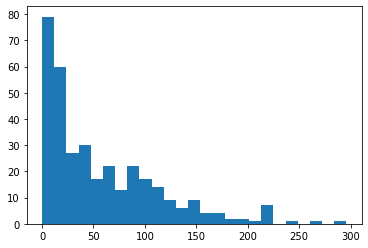

In [393]:
plt.hist(ranks_mismatch, 25)

In [394]:
sortedIndex_model = np.argsort(testSet_model_bigger_than_ranks)
sortedIndex_real  = np.argsort(testSet_real_bigger_than_ranks)


In [395]:
copy_model = np.empty(sortedIndex_model.shape[0])
copy_real = np.empty(sortedIndex_real.shape[0])
copy_model[:] = -1
copy_real[:] = -1

In [396]:
np.min(copy_model), np.max(copy_model), np.min(copy_real), np.max(copy_real)

(-1.0, -1.0, -1.0, -1.0)

In [397]:
val = 0
for order in sortedIndex_model:
    copy_model[order] = val
    val += 1
    
val = 0
for order in sortedIndex_real:
    copy_real[order] = val
    val += 1

In [398]:
# Just for checking
for index, rank in enumerate(copy_model):
    #print(rank)
    if rank == -1:
        print(index)
    
    if rank == 0:
        print('Index {} is bigger than {} other samples in the model.'.format(index, rank))
    
    if rank == sortedIndex_model.shape[0] - 1:
        print('Index {} is bigger than {} other samples in the model.'.format(index, rank))
        
for index, rank in enumerate(copy_real):
    #print(rank)
    if rank == -1:
        print(index)
    
    if rank == 0:
        print('Index {} is bigger than {} other samples actually.'.format(index, rank))
    
    if rank == sortedIndex_real.shape[0] - 1:
        print('Index {} is bigger than {} other samples  actually.'.format(index, rank))

Index 37 is bigger than 0.0 other samples in the model.
Index 305 is bigger than 347.0 other samples in the model.
Index 267 is bigger than 0.0 other samples actually.
Index 305 is bigger than 347.0 other samples  actually.


In [399]:
np.min(copy_real), np.max(copy_real), np.min(copy_model), np.max(copy_model)

(0.0, 347.0, 0.0, 347.0)

In [384]:
import scipy.stats as stats

In [400]:
tau, p_value = stats.kendalltau(copy_real, copy_model)

In [401]:
tau

0.5090927158898937

In [402]:
p_value

1.3234676928059682e-45

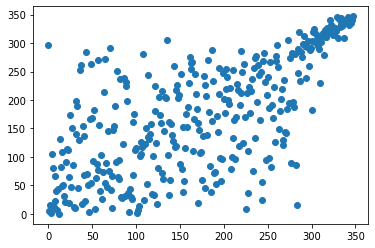

In [403]:
plt.scatter(copy_real, copy_model)

<BarContainer object of 348 artists>

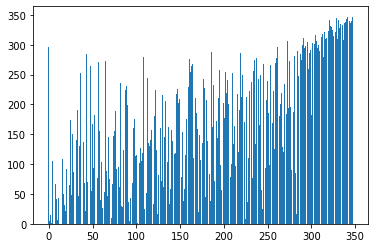

In [404]:
plt.bar(copy_real, copy_model)

# COMPETITION DATA

In [261]:
competition_data = pd.read_csv('./proteindata/test.csv', index_col = False)

In [262]:
competition_data

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [263]:
x_competition = competition_data['protein_sequence'].tolist()

In [264]:
ph_competition = competition_data['pH'].tolist()

In [265]:
# LOAD TEST WILDTYPE
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

# Dont run the cell below if you have the competition embeddings saved!


In [266]:
x_competition_embed  = []

for i, sequence in enumerate(x_competition):
    print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    x_competition_embed.append(embed)

Working on sequence 0...


NameError: name 'ESMembedding' is not defined

In [ ]:
import pickle

with open("competition_embeds_pl_new", "wb") as fp:   #Pickling
    #pickle.dump(x_competition_embed, fp)

# Instead load the saved embeddings!


In [267]:
import pickle
with open("competition_embeds_pl_new", "rb") as fp:
    x_competition_embed = pickle.load(fp)

In [268]:
x_competition[:5]

['VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPK

In [269]:
x_competition_embed[:5]

[array([-0.05348419, -0.0577033 , -0.15324247, ..., -0.10081477,
         0.00437558,  0.10947983], dtype=float32),
 array([-0.05385044, -0.05386613, -0.16091336, ..., -0.094506  ,
         0.00279988,  0.1078918 ], dtype=float32),
 array([-0.05591825, -0.05563816, -0.15555942, ..., -0.10034766,
         0.00449493,  0.10842798], dtype=float32),
 array([-0.05603744, -0.04441665, -0.15105218, ..., -0.09418205,
        -0.00062137,  0.10995836], dtype=float32),
 array([-0.05250967, -0.04570286, -0.14952633, ..., -0.08603902,
        -0.00391663,  0.11597865], dtype=float32)]

In [270]:
x_competition_embed_new = [x.reshape([1, -1]) for x in x_competition_embed]

In [271]:
x_competition_embed_new2 = np.vstack(x_competition_embed_new)

In [272]:
train_ph_list = np.array(ph_competition).reshape([-1, 1])

In [273]:
train_ph_np_normalized = train_ph_list / 14

In [274]:
x_competition_embed_with_ph = np.hstack([x_competition_embed_new2, train_ph_np_normalized])

In [275]:
x_competition_embed_with_ph.shape

(2413, 1281)

In [276]:
x_competition_embed_with_ph[:5]

array([[-0.05348419, -0.0577033 , -0.15324247, ...,  0.00437558,
         0.10947983,  0.57142857],
       [-0.05385044, -0.05386613, -0.16091336, ...,  0.00279988,
         0.1078918 ,  0.57142857],
       [-0.05591825, -0.05563816, -0.15555942, ...,  0.00449493,
         0.10842798,  0.57142857],
       [-0.05603744, -0.04441665, -0.15105218, ..., -0.00062137,
         0.10995836,  0.57142857],
       [-0.05250967, -0.04570286, -0.14952633, ..., -0.00391663,
         0.11597865,  0.57142857]])

In [277]:
test_index = 1500
embed = x_competition_embed_with_ph[index]
print(embed)
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embed)
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

[-0.05652719 -0.05279576 -0.15317661 ... -0.00216204  0.10769878
  0.57142857]


NameError: name 'getDualRegressionFromEmbedding' is not defined

In [ ]:
plt.hist(res,100)
#plt.xlim([25, 125])
plt.show()

In [ ]:
np.std(res)

In [ ]:
np.mean(res) * 100, np.median(res) * 100

# Regression using the entire train data

In [ ]:
y_competition  = []
modelnn.eval()

for i, embed in enumerate(x_competition_embed_with_ph):
    
    diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embed)
    res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)
    print("Working on sequence {}... result is {}".format(i, np.median(res)))
    y_competition.append(np.median(res))

In [ ]:
plt.plot(y_competition)

# Regression by comparing each sample with all the other samples in test

In [278]:
y_competition_from_testComps  = []
modelnn.eval()

for i in range(len(x_competition_embed_with_ph)):
    
    estimates = getDualRegressionFromTestEmbedding(i, x_competition_embed_with_ph) * 100
    print("Working on sequence {}... result is: Mean {}, Median {}, std {}".format(i, np.mean(estimates), np.median(estimates), np.std(estimates)))
    y_competition_from_testComps.append([np.mean(estimates), np.median(estimates), np.std(estimates)])

NameError: name 'getDualRegressionFromTestEmbedding' is not defined

In [ ]:
y_competition_from_testComps[:5]

In [ ]:
y_competition_means = [mean_median_std[0] for mean_median_std in y_competition_from_testComps]

In [ ]:
plt.plot(y_competition_means)

In [ ]:
y_competition_medians = [mean_median_std[1] for mean_median_std in y_competition_from_testComps]

In [ ]:
plt.plot(y_competition_medians)

In [ ]:
plt.scatter(y_competition_medians, y_competition_means)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

In [ ]:
y_competition_stds = [mean_median_std[2] for mean_median_std in y_competition_from_testComps]

In [ ]:
plt.plot(y_competition_stds)

# Regression by comparing each sample with the wild type!

In [ ]:
# Exaple for testing the function to use as guide
difference = compareTwo(embd1, embd2) #Estimates tm(embed2) - tm(embed1)
print(difference * 100)
print(y_test[index2] - y_test[index1])

In [ ]:
base

In [ ]:
wildembed = ESMembedding(base)

In [ ]:
wildembed = np.append(wildembed, 8 / 14) #Just adding the pH

In [ ]:
wildembed

In [ ]:
y_competition  = []
modelnn.eval()

for i, embed in enumerate(x_competition_embed_with_ph):
    
    difference = compareTwo(wildembed, embed)  * 100
    print("Index {}... difference is {}".format(i, difference))
    y_competition.append(difference)

In [ ]:
plt.plot(y_competition)

## Using compareTwo just as comparator and compare each sample to the rest!

In [405]:
bigger_than_ranks  = []
modelnn.eval()

for index1, embed1 in enumerate(x_competition_embed_with_ph):
    
    index1_bigger_than = 0
    for index2, embed2 in enumerate(x_competition_embed_with_ph):
        if index1 == index2:
            continue
        difference = compareTwo(embed1, embed2)  * 100 # if negative: embed1>embed2 and if positive embed1<embed2
    
        if difference > 0:
            #print("Index {} < Index {}".format(index1, index2))
            pass
        else:
            #print("Index {} > Index {}".format(index1, index2))
            index1_bigger_than += 1

    bigger_than_ranks.append(index1_bigger_than)
    print("Index {} is bigger than {} others".format(index1, index1_bigger_than))
    

Index 0 is bigger than 329 others
Index 1 is bigger than 862 others
Index 2 is bigger than 501 others
Index 3 is bigger than 352 others
Index 4 is bigger than 626 others
Index 5 is bigger than 586 others
Index 6 is bigger than 192 others
Index 7 is bigger than 86 others
Index 8 is bigger than 1480 others
Index 9 is bigger than 601 others
Index 10 is bigger than 1765 others
Index 11 is bigger than 958 others
Index 12 is bigger than 1831 others
Index 13 is bigger than 1204 others
Index 14 is bigger than 59 others
Index 15 is bigger than 124 others
Index 16 is bigger than 1249 others
Index 17 is bigger than 16 others
Index 18 is bigger than 724 others
Index 19 is bigger than 2124 others
Index 20 is bigger than 381 others
Index 21 is bigger than 152 others
Index 22 is bigger than 357 others
Index 23 is bigger than 267 others
Index 24 is bigger than 307 others
Index 25 is bigger than 1578 others
Index 26 is bigger than 1368 others
Index 27 is bigger than 1728 others
Index 28 is bigger than 

Index 227 is bigger than 1249 others
Index 228 is bigger than 146 others
Index 229 is bigger than 1227 others
Index 230 is bigger than 152 others
Index 231 is bigger than 373 others
Index 232 is bigger than 597 others
Index 233 is bigger than 1266 others
Index 234 is bigger than 127 others
Index 235 is bigger than 1765 others
Index 236 is bigger than 1659 others
Index 237 is bigger than 724 others
Index 238 is bigger than 2178 others
Index 239 is bigger than 935 others
Index 240 is bigger than 1849 others
Index 241 is bigger than 792 others
Index 242 is bigger than 996 others
Index 243 is bigger than 1207 others
Index 244 is bigger than 1346 others
Index 245 is bigger than 2027 others
Index 246 is bigger than 1238 others
Index 247 is bigger than 1396 others
Index 248 is bigger than 1292 others
Index 249 is bigger than 1364 others
Index 250 is bigger than 2059 others
Index 251 is bigger than 2221 others
Index 252 is bigger than 1973 others
Index 253 is bigger than 2089 others
Index 254 

Index 451 is bigger than 1122 others
Index 452 is bigger than 1824 others
Index 453 is bigger than 1601 others
Index 454 is bigger than 1408 others
Index 455 is bigger than 2284 others
Index 456 is bigger than 2236 others
Index 457 is bigger than 445 others
Index 458 is bigger than 306 others
Index 459 is bigger than 640 others
Index 460 is bigger than 144 others
Index 461 is bigger than 2374 others
Index 462 is bigger than 1531 others
Index 463 is bigger than 451 others
Index 464 is bigger than 988 others
Index 465 is bigger than 529 others
Index 466 is bigger than 639 others
Index 467 is bigger than 1406 others
Index 468 is bigger than 828 others
Index 469 is bigger than 311 others
Index 470 is bigger than 701 others
Index 471 is bigger than 1406 others
Index 472 is bigger than 272 others
Index 473 is bigger than 723 others
Index 474 is bigger than 1146 others
Index 475 is bigger than 1020 others
Index 476 is bigger than 358 others
Index 477 is bigger than 1943 others
Index 478 is bi

Index 676 is bigger than 764 others
Index 677 is bigger than 127 others
Index 678 is bigger than 1841 others
Index 679 is bigger than 184 others
Index 680 is bigger than 2269 others
Index 681 is bigger than 604 others
Index 682 is bigger than 2185 others
Index 683 is bigger than 898 others
Index 684 is bigger than 1204 others
Index 685 is bigger than 880 others
Index 686 is bigger than 1567 others
Index 687 is bigger than 1692 others
Index 688 is bigger than 719 others
Index 689 is bigger than 2239 others
Index 690 is bigger than 1759 others
Index 691 is bigger than 1597 others
Index 692 is bigger than 111 others
Index 693 is bigger than 1510 others
Index 694 is bigger than 249 others
Index 695 is bigger than 32 others
Index 696 is bigger than 88 others
Index 697 is bigger than 169 others
Index 698 is bigger than 36 others
Index 699 is bigger than 439 others
Index 700 is bigger than 1563 others
Index 701 is bigger than 26 others
Index 702 is bigger than 1867 others
Index 703 is bigger 

Index 900 is bigger than 167 others
Index 901 is bigger than 308 others
Index 902 is bigger than 1515 others
Index 903 is bigger than 997 others
Index 904 is bigger than 1882 others
Index 905 is bigger than 2231 others
Index 906 is bigger than 668 others
Index 907 is bigger than 862 others
Index 908 is bigger than 1533 others
Index 909 is bigger than 2250 others
Index 910 is bigger than 1483 others
Index 911 is bigger than 1092 others
Index 912 is bigger than 893 others
Index 913 is bigger than 2082 others
Index 914 is bigger than 2208 others
Index 915 is bigger than 1469 others
Index 916 is bigger than 2279 others
Index 917 is bigger than 1441 others
Index 918 is bigger than 2314 others
Index 919 is bigger than 1225 others
Index 920 is bigger than 958 others
Index 921 is bigger than 1667 others
Index 922 is bigger than 1662 others
Index 923 is bigger than 1712 others
Index 924 is bigger than 640 others
Index 925 is bigger than 625 others
Index 926 is bigger than 858 others
Index 927 i

Index 1121 is bigger than 1492 others
Index 1122 is bigger than 787 others
Index 1123 is bigger than 1561 others
Index 1124 is bigger than 661 others
Index 1125 is bigger than 1029 others
Index 1126 is bigger than 2052 others
Index 1127 is bigger than 1847 others
Index 1128 is bigger than 2083 others
Index 1129 is bigger than 1416 others
Index 1130 is bigger than 977 others
Index 1131 is bigger than 1552 others
Index 1132 is bigger than 2073 others
Index 1133 is bigger than 775 others
Index 1134 is bigger than 1304 others
Index 1135 is bigger than 1031 others
Index 1136 is bigger than 945 others
Index 1137 is bigger than 564 others
Index 1138 is bigger than 1227 others
Index 1139 is bigger than 581 others
Index 1140 is bigger than 1800 others
Index 1141 is bigger than 382 others
Index 1142 is bigger than 2291 others
Index 1143 is bigger than 1258 others
Index 1144 is bigger than 467 others
Index 1145 is bigger than 906 others
Index 1146 is bigger than 1605 others
Index 1147 is bigger t

Index 1340 is bigger than 1220 others
Index 1341 is bigger than 1537 others
Index 1342 is bigger than 2342 others
Index 1343 is bigger than 1347 others
Index 1344 is bigger than 1212 others
Index 1345 is bigger than 2395 others
Index 1346 is bigger than 2220 others
Index 1347 is bigger than 1321 others
Index 1348 is bigger than 1656 others
Index 1349 is bigger than 1828 others
Index 1350 is bigger than 1606 others
Index 1351 is bigger than 202 others
Index 1352 is bigger than 576 others
Index 1353 is bigger than 1292 others
Index 1354 is bigger than 776 others
Index 1355 is bigger than 450 others
Index 1356 is bigger than 857 others
Index 1357 is bigger than 629 others
Index 1358 is bigger than 1193 others
Index 1359 is bigger than 1799 others
Index 1360 is bigger than 1761 others
Index 1361 is bigger than 1699 others
Index 1362 is bigger than 1380 others
Index 1363 is bigger than 2264 others
Index 1364 is bigger than 1477 others
Index 1365 is bigger than 2370 others
Index 1366 is bigg

Index 1558 is bigger than 144 others
Index 1559 is bigger than 138 others
Index 1560 is bigger than 197 others
Index 1561 is bigger than 1587 others
Index 1562 is bigger than 1300 others
Index 1563 is bigger than 567 others
Index 1564 is bigger than 860 others
Index 1565 is bigger than 762 others
Index 1566 is bigger than 2124 others
Index 1567 is bigger than 1321 others
Index 1568 is bigger than 939 others
Index 1569 is bigger than 1700 others
Index 1570 is bigger than 973 others
Index 1571 is bigger than 1955 others
Index 1572 is bigger than 1074 others
Index 1573 is bigger than 1496 others
Index 1574 is bigger than 1975 others
Index 1575 is bigger than 1870 others
Index 1576 is bigger than 2092 others
Index 1577 is bigger than 2230 others
Index 1578 is bigger than 1532 others
Index 1579 is bigger than 723 others
Index 1580 is bigger than 1414 others
Index 1581 is bigger than 2119 others
Index 1582 is bigger than 1122 others
Index 1583 is bigger than 1726 others
Index 1584 is bigger 

Index 1777 is bigger than 148 others
Index 1778 is bigger than 281 others
Index 1779 is bigger than 1057 others
Index 1780 is bigger than 684 others
Index 1781 is bigger than 1504 others
Index 1782 is bigger than 701 others
Index 1783 is bigger than 623 others
Index 1784 is bigger than 217 others
Index 1785 is bigger than 212 others
Index 1786 is bigger than 329 others
Index 1787 is bigger than 102 others
Index 1788 is bigger than 330 others
Index 1789 is bigger than 351 others
Index 1790 is bigger than 808 others
Index 1791 is bigger than 1927 others
Index 1792 is bigger than 689 others
Index 1793 is bigger than 609 others
Index 1794 is bigger than 167 others
Index 1795 is bigger than 997 others
Index 1796 is bigger than 851 others
Index 1797 is bigger than 2114 others
Index 1798 is bigger than 345 others
Index 1799 is bigger than 392 others
Index 1800 is bigger than 1585 others
Index 1801 is bigger than 243 others
Index 1802 is bigger than 654 others
Index 1803 is bigger than 2145 ot

Index 1997 is bigger than 1426 others
Index 1998 is bigger than 1818 others
Index 1999 is bigger than 2004 others
Index 2000 is bigger than 1802 others
Index 2001 is bigger than 2120 others
Index 2002 is bigger than 1650 others
Index 2003 is bigger than 1448 others
Index 2004 is bigger than 1429 others
Index 2005 is bigger than 1647 others
Index 2006 is bigger than 1726 others
Index 2007 is bigger than 1814 others
Index 2008 is bigger than 348 others
Index 2009 is bigger than 831 others
Index 2010 is bigger than 316 others
Index 2011 is bigger than 433 others
Index 2012 is bigger than 754 others
Index 2013 is bigger than 1453 others
Index 2014 is bigger than 533 others
Index 2015 is bigger than 356 others
Index 2016 is bigger than 447 others
Index 2017 is bigger than 1334 others
Index 2018 is bigger than 375 others
Index 2019 is bigger than 377 others
Index 2020 is bigger than 571 others
Index 2021 is bigger than 655 others
Index 2022 is bigger than 2237 others
Index 2023 is bigger tha

Index 2215 is bigger than 1176 others
Index 2216 is bigger than 2326 others
Index 2217 is bigger than 2362 others
Index 2218 is bigger than 1583 others
Index 2219 is bigger than 1291 others
Index 2220 is bigger than 1478 others
Index 2221 is bigger than 2132 others
Index 2222 is bigger than 759 others
Index 2223 is bigger than 1398 others
Index 2224 is bigger than 933 others
Index 2225 is bigger than 729 others
Index 2226 is bigger than 571 others
Index 2227 is bigger than 2337 others
Index 2228 is bigger than 440 others
Index 2229 is bigger than 1163 others
Index 2230 is bigger than 1004 others
Index 2231 is bigger than 1621 others
Index 2232 is bigger than 2081 others
Index 2233 is bigger than 1668 others
Index 2234 is bigger than 2150 others
Index 2235 is bigger than 1340 others
Index 2236 is bigger than 2084 others
Index 2237 is bigger than 1037 others
Index 2238 is bigger than 1820 others
Index 2239 is bigger than 2023 others
Index 2240 is bigger than 1485 others
Index 2241 is big

In [406]:
bigger_than_ranks

[329,
 862,
 501,
 352,
 626,
 586,
 192,
 86,
 1480,
 601,
 1765,
 958,
 1831,
 1204,
 59,
 124,
 1249,
 16,
 724,
 2124,
 381,
 152,
 357,
 267,
 307,
 1578,
 1368,
 1728,
 462,
 1695,
 74,
 577,
 1443,
 1192,
 673,
 2301,
 1237,
 965,
 314,
 769,
 174,
 119,
 227,
 1283,
 1854,
 1013,
 1439,
 1934,
 517,
 519,
 1903,
 1608,
 247,
 1813,
 2356,
 1342,
 1168,
 2098,
 1957,
 1124,
 1575,
 1242,
 1853,
 585,
 1649,
 2108,
 940,
 2174,
 2148,
 740,
 1322,
 1953,
 1201,
 2216,
 560,
 1258,
 1684,
 2252,
 2275,
 1074,
 596,
 197,
 405,
 349,
 373,
 643,
 61,
 575,
 1548,
 873,
 406,
 1978,
 952,
 256,
 1593,
 1397,
 647,
 580,
 773,
 583,
 2198,
 1020,
 686,
 632,
 1144,
 462,
 676,
 324,
 523,
 193,
 435,
 139,
 905,
 1507,
 1113,
 1157,
 1464,
 1755,
 1729,
 1202,
 1455,
 1009,
 844,
 859,
 1874,
 1966,
 1637,
 1706,
 1906,
 1775,
 1437,
 2192,
 1491,
 1152,
 1431,
 2185,
 1558,
 1930,
 931,
 543,
 878,
 1702,
 610,
 312,
 332,
 1078,
 176,
 2291,
 1811,
 2091,
 2384,
 1139,
 1852,
 1908

In [407]:
sortedIndex = np.argsort(bigger_than_ranks)

In [408]:
sortedIndex

array([1850, 1650, 1856, ...,  597,  525,  536], dtype=int64)

In [409]:
sortedIndex.shape

(2413,)

In [410]:
copy = np.empty(sortedIndex.shape[0])
copy[:] = -1 

In [411]:
np.min(copy), np.max(copy)

(-1.0, -1.0)

In [412]:
copy.shape

(2413,)

In [413]:
val = 0
for order in sortedIndex:
    copy[order] = val
    val += 1

In [414]:
for index, rank in enumerate(copy):
    #print(rank)
    if rank == -1:
        print(index)
    
    if rank == 0:
        print('Index {} is bigger than {} other samples.'.format(index, rank))
    
    if rank == sortedIndex.shape[0] - 1:
        print('Index {} is bigger than {} other samples.'.format(index, rank))

Index 536 is bigger than 2412.0 other samples.
Index 1850 is bigger than 0.0 other samples.


In [415]:
np.min(copy), np.max(copy)

(0.0, 2412.0)

# Pick the approach and submit for score

In [416]:
y_competition = copy

In [417]:
y_competition

array([ 327.,  863.,  498., ..., 1188., 1367., 1207.])

In [418]:
competition_tm = [((y * 80 / 2412) + 20) for y in y_competition]

In [419]:
competition_tm

[30.845771144278608,
 48.623548922056386,
 36.51741293532338,
 31.674958540630183,
 40.79601990049751,
 39.46932006633499,
 26.334991708126037,
 22.786069651741293,
 69.12106135986733,
 39.933665008291875,
 78.67330016583747,
 51.840796019900495,
 80.79601990049751,
 59.933665008291875,
 21.923714759535656,
 24.046434494195687,
 61.459369817578775,
 20.497512437810947,
 43.98009950248756,
 90.51409618573798,
 32.70315091210614,
 25.008291873963515,
 31.807628524046436,
 28.756218905472636,
 30.149253731343286,
 72.37147595356551,
 65.30679933665007,
 77.41293532338308,
 35.42288557213931,
 76.25207296849088,
 22.487562189054728,
 39.20398009950249,
 67.92703150912106,
 59.43615257048093,
 42.32172470978441,
 96.31840796019901,
 61.06135986733002,
 51.940298507462686,
 30.381426202321727,
 45.472636815920396,
 25.737976782752902,
 23.9469320066335,
 27.562189054726367,
 62.48756218905473,
 81.62520729684908,
 53.53233830845771,
 67.72802653399668,
 84.11276948590381,
 37.18076285240464,

In [420]:
submission = pd.read_csv("./proteindata/sample_submission.csv")

In [421]:
submission

,seq_id,tm
0,31390,0
1,31391,1
2,31392,2
3,31393,3
4,31394,4
...,...,...
2408,33798,2408
2409,33799,2409
2410,33800,2410
2411,33801,2411


In [422]:
competition_tm_round = [round(x, 0) for x in competition_tm]
competition_tm_round

[31.0,
 49.0,
 37.0,
 32.0,
 41.0,
 39.0,
 26.0,
 23.0,
 69.0,
 40.0,
 79.0,
 52.0,
 81.0,
 60.0,
 22.0,
 24.0,
 61.0,
 20.0,
 44.0,
 91.0,
 33.0,
 25.0,
 32.0,
 29.0,
 30.0,
 72.0,
 65.0,
 77.0,
 35.0,
 76.0,
 22.0,
 39.0,
 68.0,
 59.0,
 42.0,
 96.0,
 61.0,
 52.0,
 30.0,
 45.0,
 26.0,
 24.0,
 28.0,
 62.0,
 82.0,
 54.0,
 68.0,
 84.0,
 37.0,
 37.0,
 83.0,
 73.0,
 28.0,
 80.0,
 98.0,
 65.0,
 59.0,
 90.0,
 85.0,
 57.0,
 72.0,
 61.0,
 82.0,
 39.0,
 75.0,
 90.0,
 51.0,
 92.0,
 91.0,
 45.0,
 64.0,
 85.0,
 60.0,
 93.0,
 39.0,
 62.0,
 76.0,
 95.0,
 95.0,
 56.0,
 40.0,
 27.0,
 33.0,
 32.0,
 32.0,
 41.0,
 22.0,
 39.0,
 71.0,
 49.0,
 33.0,
 86.0,
 52.0,
 29.0,
 73.0,
 66.0,
 41.0,
 39.0,
 46.0,
 39.0,
 93.0,
 54.0,
 43.0,
 41.0,
 58.0,
 35.0,
 42.0,
 31.0,
 37.0,
 26.0,
 34.0,
 25.0,
 50.0,
 70.0,
 57.0,
 58.0,
 69.0,
 78.0,
 77.0,
 60.0,
 68.0,
 53.0,
 48.0,
 48.0,
 82.0,
 85.0,
 74.0,
 77.0,
 83.0,
 79.0,
 68.0,
 93.0,
 70.0,
 58.0,
 68.0,
 93.0,
 72.0,
 84.0,
 51.0,
 38.0,
 49.0,
 76.0,
 40.0,

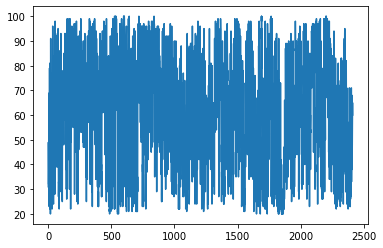

In [423]:
plt.plot(competition_tm_round)

In [424]:
submission['tm'] = competition_tm_round

In [425]:
filename_submission = "./proteindata/submission_0102_v12_LastOne.csv"

In [426]:
submission.to_csv(filename_submission, index = False)

In [427]:
!kaggle competitions submit -c novozymes-enzyme-stability-prediction -f "./proteindata/submission_0102_v12_LastOne.csv" -m Comparator

Successfully submitted to Novozymes Enzyme Stability Prediction



  0%|          | 0.00/28.3k [00:00<?, ?B/s]
 28%|##8       | 8.00k/28.3k [00:00<00:00, 78.1kB/s]
100%|##########| 28.3k/28.3k [00:02<00:00, 12.4kB/s]


In [428]:
!kaggle competitions submissions -c novozymes-enzyme-stability-prediction 

fileName                           date                 description    status    publicScore  privateScore  
---------------------------------  -------------------  -------------  --------  -----------  ------------  
submission_0102_v12_LastOne.csv    2023-01-03 12:53:12  Comparator     complete  -0.009                     
submission_0102_v11_compModel.csv  2023-01-03 08:20:15  Comparator     complete  0.074                      
submission_0102_v6_ranksC.csv      2023-01-03 03:56:24  Comparator     complete  0.018                      
submission_0102_v5_ranksC.csv      2023-01-03 00:33:38  Comparator     complete  0.045                      
submission_0102_v4_ranksC.csv      2023-01-03 00:31:45  Comparator     complete  0.045                      
submission_0102_v3_ranks.csv       2023-01-02 13:16:12  wildComp       complete  0.045                      
submission_0102_v2.csv             2023-01-02 11:22:35  wildComp       complete  0.043                      
submission_0102_v1.